# Introduction



This notebook is a template for training a PPO model in fake environment. Fake environment is a mapping of Webots grid world. The model trained in fake environment can be applied in Webots grid world. 

---
**NOTE**

To use this notebook, please first follow `UseGuide.md` to install the neccessary packages.

---

In [27]:
%%capture output 
# captures ALL output in cell to disable tensorflow warnings

import numpy as np
from stable_baselines import PPO1

In [28]:
import sys
sys.path.insert(0,'../backend')

# load our fakegym
from fakegym.fakeenv import WbtGymFake
from fakegym.state import FakeState

# Create a Custom Reward Function (optional)

You can create your own reward function and check done function in this block. These following attributes and methods are for your use：
* `gps_actual`,  get gps data for the current position.
* `gps_target`, get gps data for the target.
* `get_target_distance(normalized=False)`, calculate euclidean distance from the current position to target. `normalized` - (bool) If True, the distance will be normalized into the ratio of the actual distance to the maximum distance.
* `gps_visited_count`, the frequency of reaching the current position in the past steps
* `obs.touching`, whether the agent touchs a obstacle or not.
* `time_steps`, how many time steps the agent has used in this episode.

The reward function and check done function in the cell below is an example for you.

In [29]:
class MyEnv(WbtGymFake):
    def __init__(self, seed=None, N=10, num_of_sensors=4, obstacles_num=16, step_range=(1, 1), obs=FakeState, obs_len=1):
                  super(MyEnv, self).__init__(seed, N, num_of_sensors, obstacles_num, step_range, obs, obs_len=obs_len)

    def calc_reward(self):
        if self.gps_actual == self.gps_target:
            reward = 10000
        else:
            reward = 0

            # step penalty
            target_distance = self.get_target_distance(normalized=True)
            step_penalty = -1
            lambda_ = 5
            reward += step_penalty * (1 - np.exp(-lambda_ * target_distance))

            # visited count penalty
            vc = self.gps_visited_count
            if vc > 3:
                reward += -0.2 * (vc - 2)**2

            # touching penalty
            if self.obs.touching is True:
                reward -= 500

        return reward
           
    def check_done(self):
        if self.time_steps == 200:
            return True
        if self.gps_actual == self.gps_target:
            return True
        return False

# Select Parameters for the Training Environment

You can setup the environment parameters for your training:

* `world_size` , setup the size of environments for training. For example: `world_size = 10` will setup a square map of size 10x10. 
* `num_obstacles`, setup the number of obstacles. Each obstacle is a block of size 1x1.

In [30]:
world_size = 10
num_obstacles = 16

# Start the Fake Environment


The training environment will be created. If you want to use the custom reward class created above, please use custom cell and comment the standard cell. The situaition of the fake environment will be plotted. Yellow square represent the target, green square is the current position and the light blue parts are the obstacles. Around the map there is a wall with a thickness of 1. 

In [31]:
# standard
env = WbtGymFake(N=world_size, obstacles_num=num_obstacles)
env.render()

<Figure size 720x720 with 0 Axes>

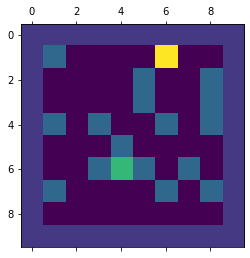

In [32]:
# # custom
# env = MyEnv(N=world_size, obstacles_num=num_obstacles)
# env.render()

# Initialize a Model from Stable-Baselines

More information of setting parameters for PPO model can be find [here](https://stable-baselines.readthedocs.io/en/master/modules/ppo1.html#parameters)

In [33]:
%%capture output 
# captures ALL output in cell to disable tensorflow warnings

model_name = "PPO_fakeenv"
model = PPO1("MlpPolicy", env)

# Train a Model on the Fake Environment


Train and a PPO model on the fake environment and save it after training. Please setup the training parameters:

* `time_steps`, the total number of samples to train on.

More information of setting parameters for model training can be find [here](https://stable-baselines.readthedocs.io/en/master/modules/ppo1.html#parameters)

In [34]:
time_steps = 100000
model.learn(total_timesteps=time_steps)
model.save('model/grid/{}'.format(model_name))
print ('Training finished :)')

Training finished :)
